<a href="https://colab.research.google.com/github/jtfreitas/QInfo_Final/blob/main/time_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from final import *
%load_ext autoreload
%autoreload 2


import tensorflow.python.util.deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


fig_dict = dict()

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data('mnist.npz')


x_train, x_test = x_train.reshape((60000, 28, 28, 1))/255, x_test.reshape((10000, 28, 28, 1))/255

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=123)
avg_input = tf.keras.layers.AveragePooling2D((2,2))

x_train_red, x_val_red, x_test_red = avg_input(x_train), avg_input(x_val), avg_input(x_test)

mnist_train = tf.data.Dataset.from_tensor_slices((x_train_red, tf.one_hot(y_train, 10))).shuffle(100).batch(3000)
mnist_val   = tf.data.Dataset.from_tensor_slices((x_val_red, tf.one_hot(y_val, 10))).shuffle(100).batch(len(x_val))
mnist_test  = tf.data.Dataset.from_tensor_slices((x_test_red, tf.one_hot(y_test, 10))).batch(len(x_test))
in_shape_mnist = x_train_red[0].shape

In [3]:
tn_MNIST = tf.keras.Sequential(
    [
     tf.keras.Input(shape=in_shape_mnist),
     Conv2D(filters=28, kernel_size=(2,2), strides=1, name='conv1', activation='relu', activity_regularizer=regularizers.l2(1e-4)),
     MaxPooling2D((2,2), name='maxpool1'),
     Flatten(),
     MNIST_TN(bond_dim = 11, activity_regularizer=regularizers.l2(1e-5))
    ])

tn_MNIST.summary()

tn_MNIST.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['Precision'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 13, 13, 28)        140       
                                                                 
 maxpool1 (MaxPooling2D)     (None, 6, 6, 28)          0         
                                                                 
 flatten (Flatten)           (None, 1008)              0         
                                                                 
 mnist_tn (MNIST_TN)         (None, 10)                7116      
                                                                 
Total params: 7,256
Trainable params: 7,256
Non-trainable params: 0
_________________________________________________________________


In [4]:
start_time = time.perf_counter_ns()
hist_dict = tn_MNIST.fit(mnist_train, validation_data=mnist_val, epochs = 50, verbose = 0, shuffle=True)
end_time = time.perf_counter_ns()

elapsed = (end_time - start_time)/1e9

print(f'MNIST tensor network took {elapsed} seconds to train')

MNIST tensor network took 25.07904117 seconds to train


In [5]:
loaded_MNIST = tf.keras.models.load_model(os.getcwd()+'/saved_models/tn_MNIST.tf')

prediction_prob = tn_MNIST.predict(mnist_test)
prediction = np.argmax(prediction_prob, axis=1)

correct_indices = y_test[prediction == y_test]
incorrect_indices = y_test[prediction != y_test]

_, score = tn_MNIST.evaluate(mnist_test)
print(f"Model scored with {score*100:.2f}% precision on the test set.")

1/1 [==============================] - 0s 53ms/step - loss: 0.1393 - precision: 0.9724
Model scored with 97.24% precision on the test set.


In [6]:
train_dir = os.getcwd() + "/fruits360/Training"
test_dir  = os.getcwd() + "/fruits360/Test"
batch_size = 3000
img_height = 50
img_width = 50
validation_split = 0.2

train_ds, val_ds, test_ds = load_fruits_dataset(train_dir, test_dir, validation_split, batch_size, img_height, img_width)


Found 67692 files belonging to 131 classes.
Using 54154 files for training.
Found 67692 files belonging to 131 classes.
Using 13538 files for validation.

Test data:
Found 22688 files belonging to 131 classes.


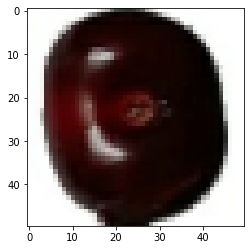

Label : 26


In [7]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

normalized_ds_train = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch_train, labels_batch_train = next(iter(normalized_ds_train))

normalized_ds_val = val_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch_val, labels_batch_val = next(iter(normalized_ds_val))

first_image = image_batch_train[0]
in_shape_fruits = first_image.shape

plt.imshow(first_image)
plt.show()
print(f"Label : {np.argmax(labels_batch_train[0])}")

In [8]:
#Building the tensor network
tn_reg_dense = regularizers.l2(1e-5)
tn_reg_conv  = regularizers.l2(1e-5)

tn_fruits = tf.keras.Sequential([
  Input(in_shape_fruits),
  Conv2D(4, kernel_size=4),
  Conv2DMPO(16, data_format = "channels_last", kernel_size=2, num_nodes=2, bond_dim=8, activation="relu", activity_regularizer = tn_reg_conv),
  MaxPooling2D(pool_size=(2,2)),
  Conv2DMPO(256, data_format = "channels_last", kernel_size=2, num_nodes=4, bond_dim=8, activation="relu", activity_regularizer = tn_reg_conv),
  MaxPooling2D(pool_size=(2,2)),
  fruit_TN1(bond_dim = 5, activity_regularizer = tn_reg_dense),
  tf.keras.layers.Dropout(0.5, name='dropout1'),
  fruit_TN2(bond_dim = 4, activity_regularizer = tn_reg_dense),
  ])

tn_fruits.summary()

lr_schedule = optimizers.schedules.ExponentialDecay(0.01, 800, 0.5)

opt = optimizers.Adam(learning_rate = lr_schedule, amsgrad=True)
tn_fruits.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['Precision'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 47, 47, 4)         196       
                                                                 
 conv2dmpo (Conv2DMPO)       (None, 47, 47, 16)        272       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 16)       0         
 )                                                               
                                                                 
 conv2dmpo_1 (Conv2DMPO)     (None, 23, 23, 256)       1536      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 256)      0         
 2D)                                                             
                                                                 
 fruit_tn1 (fruit_TN1)       (None, 64)               

In [10]:
start_time = time.perf_counter_ns()
tn_fruits_history = tn_fruits.fit(train_ds, validation_data=val_ds, epochs = 20, verbose = 0, shuffle=True)
end_time = time.perf_counter_ns()

elapsed = (end_time - start_time)/1e9

print(f'Fruits tensor network took {elapsed} seconds to train')
with open(os.getcwd()+"/hists/tn_fruit_history.json", 'w') as f:
    json.dump(tn_fruits_history.history, f)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_1/fruit_tn2/loop_body/GatherV2/pfor/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_1/fruit_tn2/loop_body/GatherV2/pfor/Reshape:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_1/fruit_tn2/loop_body/GatherV2/pfor/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_1/fruit_tn1/loop_body/GatherV2/pfor/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_1/fruit_tn1/loop_body/GatherV2/pfor/Resha

Fruits tensor network took 465.254413715 seconds to train


In [11]:
reg = regularizers.l2(0.005)
init = initializers.RandomNormal(mean = 0, stddev = 0.05)
opt = optimizers.Nadam(learning_rate = 0.01)


classic_mnist = tf.keras.Sequential()
classic_mnist.add(Conv2D(filters = 28, kernel_size = (2,2), strides=1, activation = 'relu', input_shape=(14,14,1), activity_regularizer = reg))
classic_mnist.add(MaxPooling2D(pool_size = (2, 2), strides = 2))

classic_mnist.add(Flatten())
classic_mnist.add(Dropout(0.3))
# classic_mnist.add(Dense(256,activation = 'relu'))
classic_mnist.add(Dense(10,activation = 'softmax'))

classic_mnist.summary()
classic_mnist.compile(loss = tf.keras.losses.categorical_crossentropy,
                optimizer = opt, metrics = ['Precision'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 13, 13, 28)        140       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 28)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1008)              0         
                                                                 
 dropout (Dropout)           (None, 1008)              0         
                                                                 
 dense (Dense)               (None, 10)                10090     
                                                                 
Total params: 10,230
Trainable params: 10,230
Non-trainable params: 0
__________________________________________________

In [12]:
#check_point = ModelCheckpoint(filepath = os.getcwd()+'/saved_models/trad_MNIST.tf', verbose = 0, save_best_only = True)

start_time = time.perf_counter_ns()
class_mnist_hist = classic_mnist.fit(mnist_train, validation_data=mnist_val, epochs = 10, verbose = 0, shuffle=True,)# callbacks=[check_point])
end_time = time.perf_counter_ns()

elapsed = (end_time - start_time)/1e9

print(f'Classic MNIST took {elapsed} seconds to train')
# with open(os.getcwd()+'/hists/trad_MNIST_hist.json', 'w') as f:
#     json.dump(class_mnist_hist.history, f)

Classic MNIST took 6.128148913 seconds to train


In [13]:
#Defined a model using some layer regularizers to avoid overfitting
classical_fruit = tf.keras.Sequential([
  tf.keras.Input(shape=in_shape_fruits),
  tf.keras.layers.Conv2D(4, kernel_size=4),
  tf.keras.layers.Conv2D(16, kernel_size = 2, activation='relu', kernel_regularizer=regularizers.l2(1e-5), activity_regularizer=regularizers.l2(1e-5), name='conv1'),
  tf.keras.layers.MaxPooling2D((2,2), name = 'max_pool1'),
  tf.keras.layers.Conv2D(256, kernel_size = 2, activation='relu', kernel_regularizer=regularizers.l2(1e-5), activity_regularizer=regularizers.l2(1e-5), name='conv2'),
  tf.keras.layers.MaxPooling2D((2,2), name = 'max_pool2'),
  tf.keras.layers.Flatten(name='flatten1'),
  tf.keras.layers.Dropout(0.5, name='dropout1'),
  tf.keras.layers.Dense(64, activation = 'relu', name='dense1'),
  tf.keras.layers.Dropout(0.2, name='dropout2'),
  tf.keras.layers.Dense(131, activation='softmax', name='out_dense')
])


classical_fruit.summary()


lr_schedule = optimizers.schedules.ExponentialDecay(0.01, 800, 0.1)

opt = optimizers.Adam(learning_rate = lr_schedule, amsgrad=True)
classical_fruit.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['Precision'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 47, 47, 4)         196       
                                                                 
 conv1 (Conv2D)              (None, 46, 46, 16)        272       
                                                                 
 max_pool1 (MaxPooling2D)    (None, 23, 23, 16)        0         
                                                                 
 conv2 (Conv2D)              (None, 22, 22, 256)       16640     
                                                                 
 max_pool2 (MaxPooling2D)    (None, 11, 11, 256)       0         
                                                                 
 flatten1 (Flatten)          (None, 30976)             0         
                                                                 
 dropout1 (Dropout)          (None, 30976)            

Classical fruits took 266.952619459 seconds to train.
8/8 [==============================] - 67s 195ms/step - loss: 1.8731 - precision: 0.8064
Classic fruits model scored 80.636% in test set


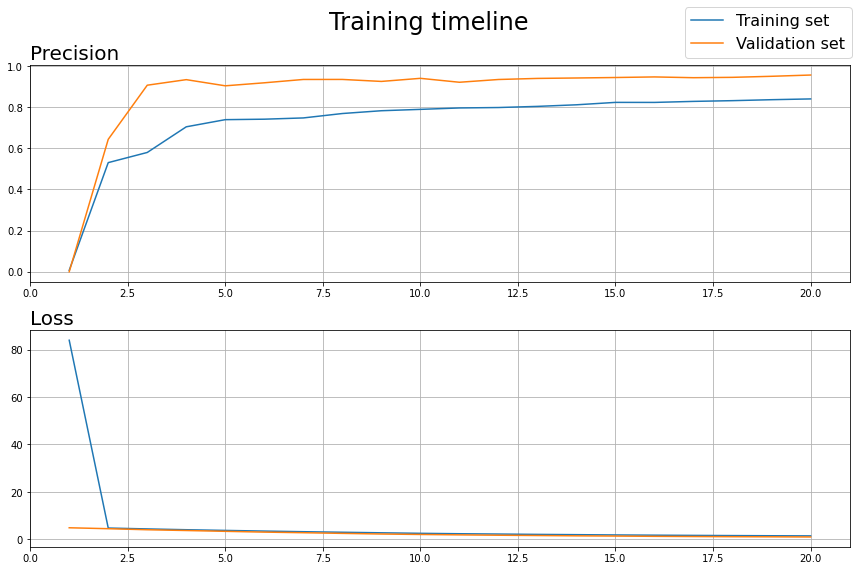

In [14]:

start_time = time.perf_counter_ns()
class_fruit_hist = classical_fruit.fit(train_ds, validation_data=val_ds, epochs = 20, verbose = 0, shuffle=True)
end_time = time.perf_counter_ns()

elapsed = (end_time - start_time)/1e9

print(f'Classical fruits took {elapsed} seconds to train.')

with open(os.getcwd()+'/hists/trad_fruit_hist.json', 'w') as f:
    json.dump(class_fruit_hist.history, f)
    
loss, score = classical_fruit.evaluate(test_ds)

print(f"Classic fruits model scored {score*100:.3f}% in test set")

classic_fruit_plot = plot_loss_acc(class_fruit_hist.history, starting_epoch = 1, figsize=(12,8), tight_layout='pad')

fig_dict['trad_fruit_history'] = classic_fruit_plot